# Data Prep & EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [284]:
# df = pd.read_parquet('data/01_cleansed.parquet')
df = pd.read_pickle('data/01_cleansed.pkl')
print(df.shape)
df.info()

(316821, 27)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 316821 entries, 0 to 316821
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    316821 non-null  object        
 1   loan_amnt             316821 non-null  int32         
 2   term                  316821 non-null  object        
 3   int_rate              316821 non-null  float64       
 4   installment           316821 non-null  float64       
 5   grade                 316821 non-null  object        
 6   sub_grade             316821 non-null  object        
 7   emp_title             316821 non-null  object        
 8   emp_length            316821 non-null  object        
 9   home_ownership        316821 non-null  object        
 10  annual_inc            316821 non-null  float64       
 11  verification_status   316821 non-null  object        
 12  loan_status           316821 non-null  object

In [285]:
df.isnull().mean().sort_values(ascending=False)*100

mort_acc                9.716212
pub_rec_bankruptcies    0.136670
revol_util              0.069755
id                      0.000000
title                   0.000000
application_type        0.000000
initial_list_status     0.000000
total_acc               0.000000
revol_bal               0.000000
pub_rec                 0.000000
open_acc                0.000000
earliest_cr_line        0.000000
dti                     0.000000
purpose                 0.000000
loan_amnt               0.000000
loan_status             0.000000
verification_status     0.000000
annual_inc              0.000000
home_ownership          0.000000
emp_length              0.000000
emp_title               0.000000
sub_grade               0.000000
grade                   0.000000
installment             0.000000
int_rate                0.000000
term                    0.000000
address                 0.000000
dtype: float64

In [286]:
# Helper to see cross tab with categorical/discrete variable against the target
def crosstab_target(df, col):
    target_col = 'loan_status'
    data = pd.crosstab(df[col],df[target_col], margins=True)
    data['pct_0'] = data['Charged Off'] / data['All'] * 100
    data['pct_1'] = data['Fully Paid'] / data['All'] * 100
    return data

# Numerical Features

This part will go through numerical features with EDA + Preprocessing.
EDA is combined here for the sake of handling features properly.

## loan_amnt

,count,mean,std,min,25%,50%,75%,max
loan_amnt,316821.0,14070.782555,8342.495955,500.0,7925.0,12000.0,20000.0,40000.0


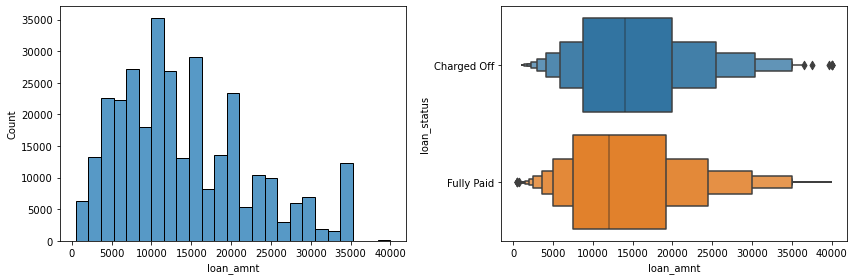

In [287]:
col = 'loan_amnt'
display(df[col].describe().to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(12,4), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

## int_rate

,count,mean,std,min,25%,50%,75%,max
int_rate,316821.0,13.530403,4.44556,5.32,10.16,13.11,16.29,30.99


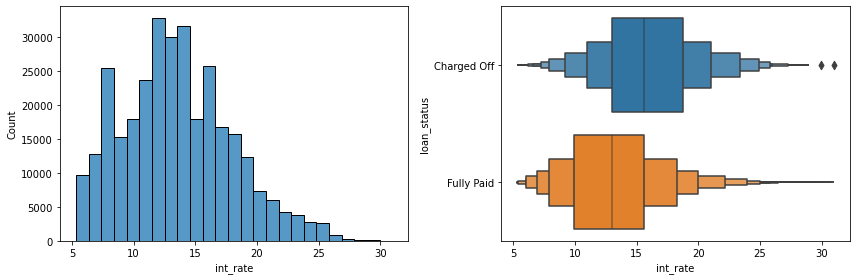

In [288]:
col = 'int_rate'
display(df[col].describe().to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(12,4), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

## installment

,count,mean,std,min,25%,50%,75%,max
installment,316821.0,431.057841,250.691557,16.08,249.55,374.92,566.44,1533.81


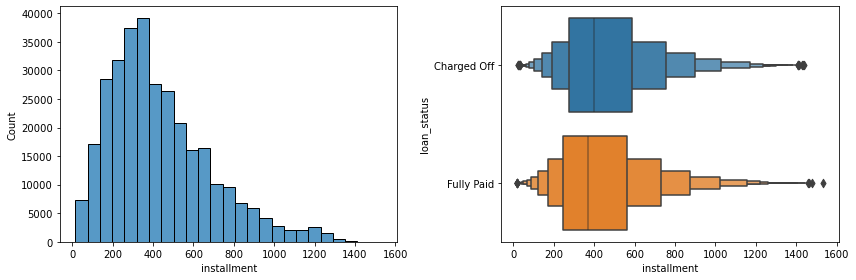

In [289]:
col = 'installment'
display(df[col].describe().to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(12,4), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

In [290]:
df[['loan_amnt','int_rate','installment']].corr()

,loan_amnt,int_rate,installment
loan_amnt,1.000000,0.164745,0.954423
int_rate,0.164745,1.000000,0.159186
installment,0.954423,0.159186,1.000000


We may choose to drop installment later, since it highly correlates with loan_amnt.

## annual_inc

,count,mean,std,min,25%,50%,75%,max
annual_inc,316821.0,74531.93796,62890.049203,600.0,45000.0,64500.0,90000.0,8706582.0


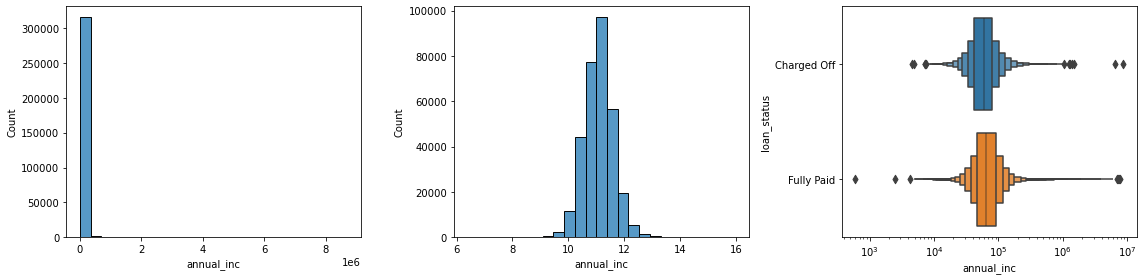

In [291]:
col = 'annual_inc'
display(df[col].describe().to_frame().T)
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.histplot(np.log(df[col]+.001), bins=25, ax=ax[1]);
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[2])
ax[2].set_xscale('log')
plt.show()

### annual_inc_adj
Handle outliers

In [292]:
threshold = df.annual_inc.mean() + df.annual_inc.std()*3
print(f"annual_inc outlier threshold: {threshold}")
df['annual_inc_adj'] = df.annual_inc.apply(lambda x: x if x < threshold else threshold)

annual_inc outlier threshold: 263202.08556788415


### annual_inc_q
Quantile cut `q=10`

In [293]:
df['annual_inc_q'] = pd.qcut(df.annual_inc, q=10)
crosstab_target(df, 'annual_inc_q')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
annual_inc_q,,,,,
"(599.999, 34000.0]",6511,25174,31685,20.549156,79.450844
"(34000.0, 42000.0]",6467,27500,33967,19.039067,80.960933
"(42000.0, 50000.0]",6779,31333,38112,17.787049,82.212951
"(50000.0, 56000.0]",4123,20328,24451,16.862296,83.137704
"(56000.0, 64500.0]",4899,25371,30270,16.184341,83.815659
"(64500.0, 72000.0]",5059,27384,32443,15.593502,84.406498
"(72000.0, 83000.0]",4481,26932,31413,14.264795,85.735205
"(83000.0, 98000.0]",4231,27769,32000,13.221875,86.778125
"(98000.0, 121000.0]",3808,26999,30807,12.360827,87.639173


### installment_inc_ratio

Installment / Monthly Income ratio

$$ratio = \frac{Monthly Installment}{Monthly Income}$$
Probably similar to DTI but looks like DTI doesn't include the requested loan.  
This measures the new debt obligation in proportion to the borrow's monthly income.

(Feature experiment)


In [294]:
# also have to handle income = 0 -> division by zero -> inf -> 0.0
df['installment_inc_ratio'] = df.installment / (df.annual_inc/12)

,count,mean,std,min,25%,50%,75%,max
installment_inc_ratio,316821.0,0.078759,0.0494,0.000123,0.047187,0.07306,0.105308,15.2998


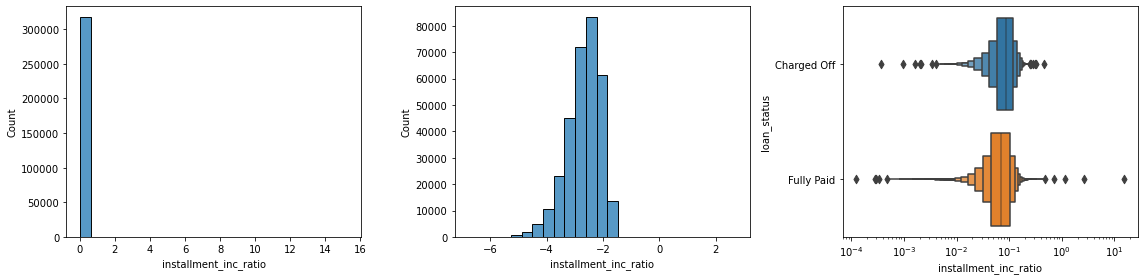

In [295]:
col = 'installment_inc_ratio'
display(df[col].describe().to_frame().T)
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.histplot(np.log(df[col]+.001), bins=25, ax=ax[1]);
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[2])
ax[2].set_xscale('log')
plt.show()

## DTI

Since there are outliers, I'll try creating 2 features

In [296]:
df.dti.describe(percentiles=[.25,.75,.9,.99])

count    316821.000000
mean         17.246776
std           8.627046
min           0.000000
25%          11.200000
50%          16.790000
75%          22.850000
90%          28.360000
99%          36.280000
max        1622.000000
Name: dti, dtype: float64

### DTI adjusted
Replace outliers with an upper bound.  
I'm using $\mu + 3 \sigma$ as a guideline threshold, and for simplicity, I choose 75.0

In [297]:
threshold = df.dti.mean() + df.dti.std()*3
print(f"dti outlier threshold: {threshold}")
df['dti_adj'] = df.dti.apply(lambda x: x if x < threshold else threshold)

dti outlier threshold: 43.12791424867872


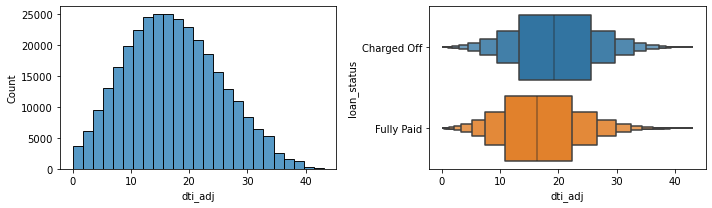

In [298]:
col = 'dti_adj'
fig, ax = plt.subplots(1,2, figsize=(10,3), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

### DTI Quantiles

In [299]:
df['dti_q'] = pd.qcut(df.dti, q=10)
crosstab_target(df, 'dti_q')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
dti_q,,,,,
"(-0.001, 6.83]",3334,28358,31692,10.520005,89.479995
"(6.83, 9.93]",3637,28155,31792,11.439985,88.560015
"(9.93, 12.38]",3879,27747,31626,12.265225,87.734775
"(12.38, 14.59]",4191,27494,31685,13.227079,86.772921
"(14.59, 16.79]",4441,27204,31645,14.033813,85.966187
"(16.79, 19.03]",4929,26793,31722,15.538112,84.461888
"(19.03, 21.47]",5174,26482,31656,16.344453,83.655547
"(21.47, 24.34]",5702,26019,31721,17.975474,82.024526
"(24.34, 28.36]",6528,25112,31640,20.632111,79.367889


Looks promising as a feature. With the higher quantiles, we get less percentage of Fully Paid.

## open_acc

,count,mean,std,min,25%,50%,75%,90%,99%,max
open_acc,316821.0,11.290287,5.12788,0.0,8.0,10.0,14.0,18.0,27.0,90.0


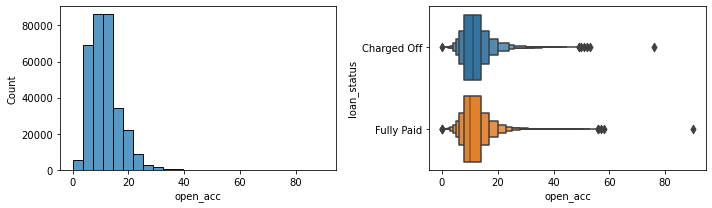

In [300]:
col = 'open_acc'
display(df[col].describe([.25,.75,.9,.99]).to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(10,3), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

## pub_rec

In [301]:
df.pub_rec.value_counts(dropna=False, normalize=True)*100

0     85.491492
1     12.502328
2      1.372699
3      0.385075
4      0.127201
5      0.058077
6      0.031248
7      0.013257
8      0.008207
9      0.002525
11     0.002525
10     0.002209
13     0.001263
86     0.000316
24     0.000316
40     0.000316
19     0.000316
17     0.000316
12     0.000316
Name: pub_rec, dtype: float64

### has_pub_rec
Whether or not pub_rec > 1

In [302]:
df['has_pub_rec'] = df['pub_rec'].gt(0).astype('int')
crosstab_target(df, 'has_pub_rec')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
has_pub_rec,,,,,
0,42011,228844,270855,15.510513,84.489487
1,7938,38028,45966,17.269286,82.730714
All,49949,266872,316821,15.765685,84.234315


## revol_bal

In [303]:
df.revol_bal.describe()

count    3.168210e+05
mean     1.585891e+04
std      2.062888e+04
min      0.000000e+00
25%      6.022000e+03
50%      1.118400e+04
75%      1.964800e+04
max      1.743266e+06
Name: revol_bal, dtype: float64

### revol_bal_adj
handle outliers

In [304]:
threshold = df.revol_bal.mean() + df.revol_bal.std()*3
print(f"revol_bal outlier threshold: {threshold}")
df['revol_bal_adj'] = df['revol_bal'].apply(lambda x: x if x < threshold else threshold)

revol_bal outlier threshold: 77745.54780029392


In [305]:
(df.revol_bal > threshold).mean()

0.012142503180029102

,count,mean,std,min,25%,50%,75%,90%,99%,max
revol_bal_adj,316821.0,15107.143549,13736.236167,0.0,6022.0,11184.0,19648.0,31504.0,77745.5478,77745.5478


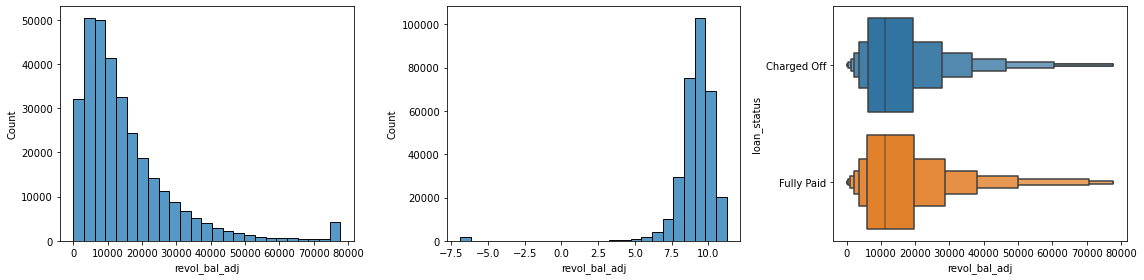

In [306]:
col = 'revol_bal_adj'
display(df[col].describe([.25,.75,.9,.99]).to_frame().T)
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.histplot(np.log(df[col]+.001), bins=25, ax=ax[1]);
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[2])
# ax[2].set_xscale('log')
plt.show()

## revol_util

In [307]:
df.revol_util.describe(percentiles=[.25,.75,.9,.99])

count    316600.000000
mean         53.606233
std          24.477192
min           0.000000
25%          35.600000
50%          54.600000
75%          72.700000
90%          86.000000
99%          98.000000
max         892.300000
Name: revol_util, dtype: float64

In [308]:
df.revol_util.isna().sum(), df.revol_util.isna().mean()*100

(221, 0.06975547706749237)

### revol_util_adj
Impute 0 and handle outliers

In [309]:
threshold = 100.0
df['revol_util_adj'] = df.revol_util.fillna(0).apply(lambda x: x if x < threshold else threshold)

,count,mean,std,min,25%,50%,75%,90%,99%,max
revol_util_adj,316821.0,53.557477,24.445179,0.0,35.6,54.6,72.7,86.0,97.9,100.0


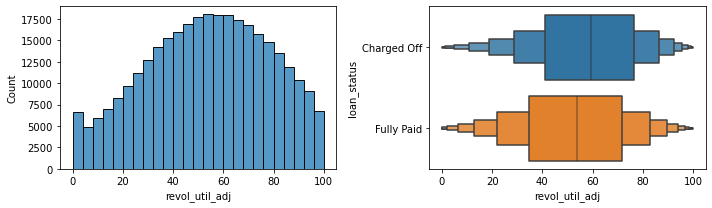

In [310]:
col = 'revol_util_adj'
display(df[col].describe([.25,.75,.9,.99]).to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(10,3), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

## total_acc

,count,mean,std,min,25%,50%,75%,90%,99%,max
total_acc,316821.0,25.421181,11.873874,2.0,17.0,24.0,32.0,41.0,60.0,150.0


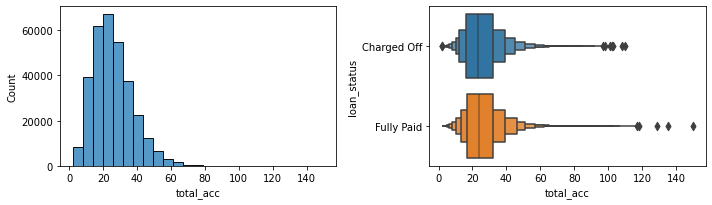

In [311]:
col = 'total_acc'
display(df[col].describe([.25,.75,.9,.99]).to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(10,3), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

## mort_acc

In [312]:
df.mort_acc.isna().value_counts(normalize=True)*100

False    90.283788
True      9.716212
Name: mort_acc, dtype: float64

### mort_acc_adj & mort_acc_missing
Impute 0 + new flag to indicate missing mort_acc

In [313]:
df['mort_acc_adj'] = df.mort_acc.fillna(0)
df['mort_acc_missing'] = df.mort_acc.isna().astype('int')

,count,mean,std,min,25%,50%,75%,90%,99%,max
mort_acc_adj,316821.0,1.652621,2.121487,0.0,0.0,1.0,3.0,5.0,8.0,34.0


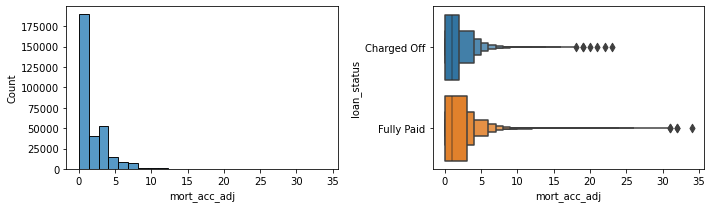

In [314]:
col = 'mort_acc_adj'
display(df[col].describe([.25,.75,.9,.99]).to_frame().T)
fig, ax = plt.subplots(1,2, figsize=(10,3), tight_layout=True)
sns.histplot(data=df, x=col, bins=25, ax=ax[0])
sns.boxenplot(data=df, x=col, y='loan_status', orient='h', ax=ax[1]);
plt.show()

In [315]:
crosstab_target(df,'mort_acc_missing')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
mort_acc_missing,,,,,
0,46346,239692,286038,16.202742,83.797258
1,3603,27180,30783,11.704512,88.295488
All,49949,266872,316821,15.765685,84.234315


## pub_rec_bankruptcies

In [316]:
df.pub_rec_bankruptcies.isna().sum()

433

In [317]:
df.pub_rec_bankruptcies.describe()

count    316388.000000
mean          0.121152
std           0.355296
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: pub_rec_bankruptcies, dtype: float64

### pub_rec_bankruptcies_adj
Impute 0

In [318]:
df['pub_rec_bankruptcies_adj'] = df.pub_rec_bankruptcies.fillna(0)

In [319]:
crosstab_target(df,'pub_rec_bankruptcies')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
pub_rec_bankruptcies,,,,,
0.0,43952,236470,280422,15.673521,84.326479
1.0,5604,28526,34130,16.419572,83.580428
2.0,263,1194,1457,18.050789,81.949211
3.0,49,234,283,17.314488,82.685512
4.0,18,43,61,29.508197,70.491803
5.0,3,20,23,13.043478,86.956522
6.0,2,5,7,28.571429,71.428571
7.0,1,2,3,33.333333,66.666667
8.0,1,1,2,50.000000,50.000000


# Categorical Features

To make a quick build of the model, I will go for Ordinal Encoding for most of the categorical features, even if some are considered nominal. Because I plan to use tree-based model, and it has a capability to learn. It will also quicker to train.
In real world scenario, we might want to comeback and experiment one-hot encoding as well, as see if it's better or not.

## term

In [320]:
crosstab_target(df, 'term')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
term,,,,,
36 months,30576,213326,243902,12.536183,87.463817
60 months,19373,53546,72919,26.567836,73.432164
All,49949,266872,316821,15.765685,84.234315


In [321]:
categories = ['36 months','60 months']
ordered = True
cat = pd.CategoricalDtype(categories=categories, ordered=ordered)
df.term = df.term.astype(cat)
df.term.value_counts()

36 months    243902
60 months     72919
Name: term, dtype: int64

## grade

In [322]:
crosstab_target(df, 'grade')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
grade,,,,,
A,2560,50435,52995,4.830644,95.169356
B,9374,85258,94632,9.905740,90.094260
C,14434,69846,84280,17.126246,82.873754
D,11794,37795,49589,23.783500,76.216500
E,7624,16580,24204,31.498926,68.501074
F,3220,5640,8860,36.343115,63.656885
G,943,1318,2261,41.707209,58.292791
All,49949,266872,316821,15.765685,84.234315


In [323]:
col = 'grade'
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
ordered = True
cat = pd.CategoricalDtype(categories=categories, ordered=ordered)
df[col] = df[col].astype(cat)
df[col].value_counts(dropna=False)

B    94632
C    84280
A    52995
D    49589
E    24204
F     8860
G     2261
Name: grade, dtype: int64

## sub_grade

In [324]:
crosstab_target(df, 'sub_grade')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
sub_grade,,,,,
A1,177,7933,8110,2.182491,97.817509
A2,289,7535,7824,3.693763,96.306237
A3,405,8361,8766,4.620123,95.379877
A4,713,12370,13083,5.449820,94.550180
A5,976,14236,15212,6.415987,93.584013
B1,1221,14565,15786,7.734702,92.265298
B2,1573,16776,18349,8.572674,91.427326
B3,2086,19684,21770,9.581994,90.418006
B4,2343,18581,20924,11.197668,88.802332


In [325]:
col = 'sub_grade'
cat = pd.CategoricalDtype(ordered=True)
df[col] = df[col].astype(cat)
df[col].value_counts(dropna=False)

B3    21770
B4    20924
C1    18939
B2    18349
C2    18002
B5    17803
C3    16915
C4    15991
B1    15786
A5    15212
C5    14433
A4    13083
D1    12665
D2    10874
D3     9498
D4     9045
A3     8766
A1     8110
A2     7824
D5     7507
E1     6096
E2     5679
E3     4819
E4     4126
E5     3484
F1     2729
F2     2106
F3     1692
F4     1297
F5     1036
G1      785
G2      545
G3      401
G4      277
G5      253
Name: sub_grade, dtype: int64

## emp_length

In [326]:
col = 'emp_length'
categories = ['', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
            '6 years', '7 years', '8 years','9 years', '10+ years']
ordered = True
df[col] = df[col].astype(pd.CategoricalDtype(categories=categories, ordered=ordered))

In [327]:
crosstab_target(df, col)

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
emp_length,,,,,
,3256,11076,14332,22.718392,77.281608
< 1 year,4204,21051,25255,16.646209,83.353791
1 year,3361,17315,20676,16.255562,83.744438
2 years,4449,24283,28732,15.484477,84.515523
3 years,3950,21405,25355,15.578781,84.421219
4 years,2962,16271,19233,15.400614,84.599386
5 years,3298,17986,21284,15.495208,84.504792
6 years,2513,14195,16708,15.040699,84.959301
7 years,2604,13940,16544,15.739845,84.260155


## home_ownership

According to the data dict, there should be only `MORTGAGE, OWN, RENT, OTHER`

In [328]:
df.home_ownership = df.home_ownership.replace({'ANY':'OTHER','NONE':'OTHER'})
df.home_ownership.value_counts(normalize=True)

MORTGAGE    0.503972
RENT        0.400722
OWN         0.094934
OTHER       0.000372
Name: home_ownership, dtype: float64

In [329]:
crosstab_target(df, 'home_ownership').sort_values('pct_1')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
home_ownership,,,,,
RENT,23277,103680,126957,18.334554,81.665446
OWN,5055,25022,30077,16.806862,83.193138
All,49949,266872,316821,15.765685,84.234315
MORTGAGE,21602,138067,159669,13.529239,86.470761
OTHER,15,103,118,12.711864,87.288136


In [330]:
col = 'home_ownership'
categories = ['RENT','OWN','MORTGAGE','OTHER']
df[col] = df[col].astype(pd.CategoricalDtype(categories=categories))
df[col]

0         MORTGAGE
1              OWN
2             RENT
3             RENT
4         MORTGAGE
            ...   
316817        RENT
316818        RENT
316819    MORTGAGE
316820        RENT
316821    MORTGAGE
Name: home_ownership, Length: 316821, dtype: category
Categories (4, object): ['RENT', 'OWN', 'MORTGAGE', 'OTHER']

### home_rent, home_own, home_mortgage

In [331]:
df['home_rent'] = (df.home_ownership=='RENT').astype('int')
df['home_own'] = (df.home_ownership=='OWN').astype('int')
df['home_mortgage'] = (df.home_ownership=='MORTGAGE').astype('int')

In [332]:
df.home_rent.mean(), df.home_own.mean(), df.home_mortgage.mean()

(0.40072154307953073, 0.09493373229678588, 0.5039722745651329)

## verification_status

In [333]:
crosstab_target(df, 'verification_status')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
verification_status,,,,,
Not Verified,11808,89779,101587,11.623535,88.376465
Source Verified,18174,86410,104584,17.377419,82.622581
Verified,19967,90683,110650,18.045188,81.954812
All,49949,266872,316821,15.765685,84.234315


In [334]:
cat = pd.CategoricalDtype(categories=['Not Verified','Source Verified','Verified'])
df.verification_status = df.verification_status.astype(cat)

### inc_verified
Whether or not income verified

In [335]:
df['inc_verified'] = (df.verification_status != 'Not Verified').astype('int')
df.inc_verified.value_counts(normalize=True)

1    0.679355
0    0.320645
Name: inc_verified, dtype: float64

In [336]:
crosstab_target(df, 'inc_verified')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
inc_verified,,,,,
0,11808,89779,101587,11.623535,88.376465
1,38141,177093,215234,17.720713,82.279287
All,49949,266872,316821,15.765685,84.234315


## purpose

In [337]:
crosstab_target(df, 'purpose').sort_values('All', ascending=False)

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
purpose,,,,,
All,49949,266872,316821,15.765685,84.234315
debt_consolidation,31170,155842,187012,16.667380,83.332620
credit_card,9012,58010,67022,13.446331,86.553669
home_improvement,2579,16639,19218,13.419711,86.580289
other,2952,13965,16917,17.449902,82.550098
major_purchase,914,6157,7071,12.926036,87.073964
small_business,1110,3377,4487,24.738132,75.261868
car,405,3423,3828,10.579937,89.420063
medical,584,2770,3354,17.412045,82.587955


In [338]:
df.purpose.astype('category').cat.categories

Index(['car', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation', 'wedding'],
      dtype='object')

In [339]:
categories = ['other', 'car', 'credit_card', 'debt_consolidation', 'educational',
               'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
               'renewable_energy', 'small_business', 'vacation', 'wedding']
df.purpose = df.purpose.astype(pd.CategoricalDtype(categories=categories))

In [340]:
df.purpose.value_counts(dropna=False, normalize=True)

debt_consolidation    0.590277
credit_card           0.211545
home_improvement      0.060659
other                 0.053396
major_purchase        0.022319
small_business        0.014163
car                   0.012083
medical               0.010586
moving                0.007099
vacation              0.006196
house                 0.005584
wedding               0.004615
renewable_energy      0.000811
educational           0.000669
Name: purpose, dtype: float64

## initial_list_status

In [341]:
df.initial_list_status = df.initial_list_status.astype('category')

In [342]:
crosstab_target(df, 'initial_list_status')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
initial_list_status,,,,,
f,29534,161118,190652,15.491052,84.508948
w,20415,105754,126169,16.180678,83.819322
All,49949,266872,316821,15.765685,84.234315


## application_type

In [343]:
crosstab_target(df, 'application_type')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
application_type,,,,,
DIRECT_PAY,61,155,216,28.240741,71.759259
INDIVIDUAL,49854,266416,316270,15.763114,84.236886
JOINT,34,301,335,10.149254,89.850746
All,49949,266872,316821,15.765685,84.234315


In [344]:
categories = ['INDIVIDUAL', 'JOINT', 'DIRECT_PAY']
df.application_type = df.application_type.astype(pd.CategoricalDtype(categories=categories))
df.application_type.value_counts(dropna=False, normalize=True)

INDIVIDUAL    0.998261
JOINT         0.001057
DIRECT_PAY    0.000682
Name: application_type, dtype: float64

## address

### state

In [345]:
df['state'] = df.address.str.split('[\s,]', regex=True).apply(lambda x: x[-2])

In [346]:
crosstab_target(df, 'state')

loan_status,Charged Off,Fully Paid,All,pct_0,pct_1
state,,,,,
AA,1775,9406,11181,15.875145,84.124855
AE,1759,9513,11272,15.605039,84.394961
AK,860,4773,5633,15.267176,84.732824
AL,857,4666,5523,15.516929,84.483071
AP,1867,9600,11467,16.281503,83.718497
AR,869,4664,5533,15.705765,84.294235
AZ,875,4678,5553,15.757248,84.242752
CA,849,4678,5527,15.360955,84.639045
CO,886,4670,5556,15.946724,84.053276


### Encoding state with income
Experiment with median, mean, coefficient of variation, and robust coefficient of variation on income by state

In [347]:
def coefficient_var(x):
    return np.std(x)/np.mean(x)

def robust_coefficient_var(x):
    q1, q3 = np.percentile(x, [25,75])
    return (q3 - q1) / (q3 + q1)

df['state_inc_med'] = df.groupby('state').annual_inc.transform('median')
df['state_inc_mean'] = df.groupby('state').annual_inc.transform('mean')
df['state_inc_cv'] = df.groupby('state').annual_inc.transform(coefficient_var)
df['state_inc_rcv'] = df.groupby('state').annual_inc.transform(robust_coefficient_var)

# Date variables

## earliest_cr_line

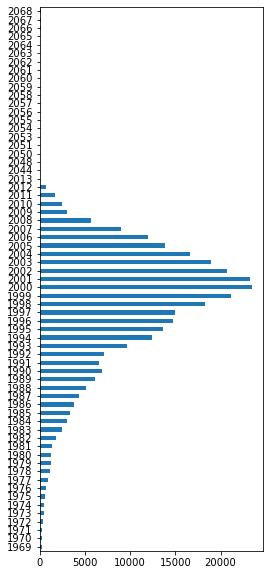

In [348]:
df.earliest_cr_line.dt.year.value_counts().sort_index().plot.barh(figsize=(4,10));

There are future dates, assuming this is not correct and will impute this with max year

### earliest_cr_year

In [360]:
df['earliest_cr_year'] = df.earliest_cr_line.dt.year
df.earliest_cr_year = df.earliest_cr_year.apply(lambda x: x if x < 2013 else 2013).astype(int)

# Target

According to the test instruction
> The outcome is to determine whether each borrower ID has loan status with percentage of likelihood of being ‘Fully Paid’. 

Fully Paid = postiive label = 1  
Charged Off = negative lebel = 0

In [362]:
categories = ['Charged Off', 'Fully Paid']
df.loan_status = df.loan_status.astype(pd.CategoricalDtype(categories=categories))
df.loan_status

0         Charged Off
1          Fully Paid
2         Charged Off
3          Fully Paid
4          Fully Paid
             ...     
316817     Fully Paid
316818     Fully Paid
316819     Fully Paid
316820     Fully Paid
316821     Fully Paid
Name: loan_status, Length: 316821, dtype: category
Categories (2, object): ['Charged Off', 'Fully Paid']

# Save file

In [366]:
# my beloved parquet doesn't support category type :(
df.to_pickle('data/02_prep.pkl')

# Categorical Encoding

Let's assume this is the first iteration of model development. I'll try to keep things simple.
I plan to use Tree-based models and they are fine with Ordinal encoding even if the categorical variable supposed to be One-hot encoded.

In [367]:
data = df.copy()



category_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                   'verification_status', 'loan_status', 'purpose', 'initial_list_status',
                   'application_type', 'annual_inc_q', 'dti_q']


# encode categorical
for col in category_cols:
    data[col] = data[col].cat.codes.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316821 entries, 0 to 316821
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        316821 non-null  object        
 1   loan_amnt                 316821 non-null  int32         
 2   term                      316821 non-null  int32         
 3   int_rate                  316821 non-null  float64       
 4   installment               316821 non-null  float64       
 5   grade                     316821 non-null  int32         
 6   sub_grade                 316821 non-null  int32         
 7   emp_title                 316821 non-null  object        
 8   emp_length                316821 non-null  int32         
 9   home_ownership            316821 non-null  int32         
 10  annual_inc                316821 non-null  float64       
 11  verification_status       316821 non-null  int32         
 12  lo

In [368]:
data.to_pickle('data/03_preprocessed.pkl')